Running a Cluster Permutation Test

Exclusion:
    - DONE during preprocessing step 1: If excluded_ec/excluded_eo/excluded_hct corresponding column is 1, then corresponding run has already been excluded from the EEG data.
    - Data-quality related exclusion
      - BAD EPOCHS (DONE during preprocessing step 3): check % excluded epochs, if > 33%, check whether if comes from one channel, if yes interpolate that channel, if not exclude person/task.
      - BAD CHANNELS:
        - Permutation Test: exclude those with more bad channels than 33%  => Remaining!
  
  Imports:

In [5]:
import matplotlib.pyplot as plt
import mne
from mne import io
from mne.datasets import sample
from mne.stats import permutation_cluster_test
import numpy as np
import pandas as pd
import os
from mne.channels import find_ch_adjacency
import scipy
from scipy.stats import t

import numpy as np
import mne
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import pingouin as pg





1) Find Exclusion Sub/Tasks

In [ ]:
# define dir for prep data csv, to detect bad subs
bhc_prep_output_dir = "/Users/denizyilmaz/Desktop/BrainTrain/Data_analysis/prep_outputs_for_analysis/HC_prep_interp_output_sampling-250_bandpass-0.30-45.00_line-50_find_all_bads_20250819.csv"
ssd_prep_output_dir = "/Users/denizyilmaz/Desktop/BrainTrain/Data_analysis/prep_outputs_for_analysis/SSD_prep_interp_output_sampling-250_bandpass-0.30-45.00_line-50_find_all_bads_20250821.csv"

# Load the csv data
bhc_prep_output = pd.read_csv(bhc_prep_output_dir)
ssd_prep_output = pd.read_csv(ssd_prep_output_dir)

# Get the list of bad subjects by detecting the subject_id, session, and task combination in the rows where "percent_interpolated_electrode" is above 33
bhc_bad_subs = bhc_prep_output[bhc_prep_output['percent_interpolated_electrode'] > 33][['subject_id', 'session', 'task']]
ssd_bad_subs = ssd_prep_output[ssd_prep_output['percent_interpolated_electrode'] > 33][['subject_id', 'session', 'task']]

# Exclude df = 
exclude_df = pd.concat([bhc_bad_subs, ssd_bad_subs], ignore_index=True)
print(exclude_df)


# create bad_subs_name list which is subject_id_session_task
bhc_bad_subs_names = []
for index, row in bhc_bad_subs.iterrows():
    bhc_bad_subs_names.append(f"{row['subject_id']}_{row['task']}_hep-ave.fif")
ssd_bad_subs_names= []
for index, row in ssd_bad_subs.iterrows():
    ssd_bad_subs_names.append(f"{row['subject_id']}_{row['session']}_{row['task']}_hep-ave.fif")


all_bad_subs_names = bhc_bad_subs_names + ssd_bad_subs_names
# Print the bad subjects
print("BHC Bad Subjects:")
print(bhc_bad_subs_names)
print("SSD Bad Subjects:")          
print(ssd_bad_subs_names)
print("All Bad Subjects:")
print(all_bad_subs_names)
    
#print(bhc_bad_subs["subject_id"])
#print(bhc_bad_subs)
#print(bhc_bad_subs_names)
#type(bhc_bad_subs)
#print(ssd_bad_subs_names)



2) Import Evoked Objects, which do not include more than 33% interpolated channels & Create dictionaries storing all evoked data. 

In [ ]:
# Define paths
base_path = '/Users/denizyilmaz/Desktop/BrainTrain/BrainTrain_EEG_data/Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/Preprocessed_ICA_applied_on_raw/HEPs/HEPs_hep-epoch--0.25-0.55_baseline--0.12--0.03_epoch-reject-1.50e-04_33%-bad-epochs-threshold_HEP-time_window-0.45-0.50/with-double-R-peak-exclusion'
base_path_hc = '/Users/denizyilmaz/Desktop/BrainTrain/Healthy Controls_BHC/BrainTrain_EEG_data_HC/HC_Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/HC_Preprocessed_ICA_applied_on_raw/HEPs/HEPs_hep-epoch--0.25-0.55_baseline--0.12--0.03_epoch-reject-1.50e-04_33%-bad-epochs-threshold_HEP-time_window-0.45-0.50/with-double-R-peak-exclusion'

# Function to process data folders
def import_evoked_data(base_path, task_dictionaries, all_bad_subs_names, has_session_folder=False):
    for folder_name in os.listdir(base_path):
        # Construct folder path
        folder_path = os.path.join(base_path, folder_name)
        if has_session_folder:
            folder_path = os.path.join(folder_path, "ses-V1")
        
        if not os.path.isdir(folder_path):
            continue  # Skip non-folder entries

        print(f"Processing folder: {folder_path}")

        # Loop over the task subfolders
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if not os.path.isdir(subfolder_path):
                continue

            # Check if the subfolder name matches one of the tasks
            task_key = None
            if subfolder_name == "task-eyes-closed":
                task_key = "ec"
            elif subfolder_name == "task-eyes-open":
                task_key = "eo"
            elif subfolder_name == "task-hct":
                task_key = "hct"
            else:
                print(f"Unknown subfolder: {subfolder_name}")
                continue

            for file_name in os.listdir(subfolder_path):
                print(file_name)
                # Check for exclusions
                excluded = False
                if file_name in all_bad_subs_names:
                    print(f"Excluded due to bad subject: {file_name}")
                    excluded = True
                    break

                #for row in exclude_df.itertuples(index=False):
                #    subject_id, session, task = row.subject_id, row.session, row.task
                #    if subject_id in file_name and task in file_name and (not has_session_folder or session in file_name):
                #        print(f"Excluded due to {subject_id}-{session}-{task}: {file_name}")
                #        excluded = True
                #        break

                if excluded:
                    continue

                # Import the data if not excluded
                file_path = os.path.join(subfolder_path, file_name)
                try:
                    data = mne.read_evokeds(file_path, verbose=False)
                    task_dictionaries[task_key][file_name] = data
                    print(f"Imported: {file_name}")
                except Exception as e:
                    print(f"Error importing {file_name} from {file_path}: {e}")

# Create dictionaries for SSD data
ssd_data_v1 = {"ec": {}, "eo": {}, "hct": {}}
import_evoked_data(base_path, ssd_data_v1, all_bad_subs_names, has_session_folder=True)



# Print the keys of the imported SSD data
print(f"Final imported SSD ec keys: {list(ssd_data_v1['ec'].keys())}")
print(f"Final imported SSD eo keys: {list(ssd_data_v1['eo'].keys())}")
print(f"Final imported SSD hct keys: {list(ssd_data_v1['hct'].keys())}")

# Create dictionaries for HC data
hc_data = {"ec": {}, "eo": {}, "hct": {}}
import_evoked_data(base_path_hc, hc_data, all_bad_subs_names, has_session_folder=False)

# Print the keys of the imported HC data
print(f"Final imported HC ec keys: {list(hc_data['ec'].keys())}")
print(f"Final imported HC eo keys: {list(hc_data['eo'].keys())}")
print(f"Final imported HC hct keys: {list(hc_data['hct'].keys())}")


In [9]:
a = hc_data['ec']['BHC001_eyes-closed_hep-ave.fif'][0] 
a.data.shape # channels x timepoints

(31, 201)

In [ ]:
# unboxing: take each evoked out of the lists in the dictionary values
hc_ec_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in hc_data['ec'].values()]
hc_ec_grand = mne.grand_average(hc_ec_evokeds_all_subs_flat)
hc_ec_grand.plot()
hc_eo_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in hc_data['eo'].values()]
hc_eo_grand = mne.grand_average(hc_eo_evokeds_all_subs_flat)
hc_eo_grand.plot()
hc_hct_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in hc_data['hct'].values()]
hc_hct_grand = mne.grand_average(hc_hct_evokeds_all_subs_flat)

#ssd
ssd_ec_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in ssd_data_v1['ec'].values()]
ssd_ec_grand = mne.grand_average(ssd_ec_evokeds_all_subs_flat)
ssd_ec_grand.plot()
ssd_eo_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in ssd_data_v1['eo'].values()]
ssd_eo_grand = mne.grand_average(ssd_eo_evokeds_all_subs_flat)
ssd_eo_grand.plot()
ssd_hct_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in ssd_data_v1['hct'].values()]
ssd_hct_grand = mne.grand_average(ssd_hct_evokeds_all_subs_flat)
ssd_hct_grand.plot()


3.1) Get the time window & task & channels of interest for SPATIAL CLUSTER PERM TEST

In [ ]:

# Define the time window of interest
time_min = 0.35 #0.45
time_max = 0.55 #0.7 #0.50
# Specify the task and channels
tasks = ["ec", "eo", "hct"]
#task = "ec"  # Example: "ec", "eo", or "hct"
channels_of_interest = list(range(0, 31))  # Example: indices of the desired channels
channels = ssd_hct_grand.ch_names

# Extract SSD group data
ssd_group_data_for_spatial_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    temp_list = []

    for evoked in ssd_data_v1[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            ssd_group_data_for_spatial_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute

    # make array
    ssd_group_data_for_spatial_test[task] = np.array(ssd_group_data_for_spatial_test[task])  # Shape:
ssd_group_data_for_spatial_test_ec_array = ssd_group_data_for_spatial_test["ec"]
ssd_group_data_for_spatial_test_eo_array = ssd_group_data_for_spatial_test["eo"]
ssd_group_data_for_spatial_test_hct_array = ssd_group_data_for_spatial_test["hct"]


# Extract HC group data
hc_group_data_for_spatial_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    temp_list = []
    for evoked in hc_data[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            hc_group_data_for_spatial_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute

    # make array
    hc_group_data_for_spatial_test[task] = np.array(hc_group_data_for_spatial_test[task])  # Shape:

hc_group_data_for_spatial_test_ec_array = hc_group_data_for_spatial_test["ec"]
hc_group_data_for_spatial_test_eo_array = hc_group_data_for_spatial_test["eo"]
hc_group_data_for_spatial_test_hct_array = hc_group_data_for_spatial_test["hct"]


shape_ssd = ssd_group_data_for_spatial_test_ec_array.shape
shape_hc = hc_group_data_for_spatial_test_ec_array.shape
print(f"SSD group data shape: {shape_ssd} indicating {shape_ssd[0]} subjects, {shape_ssd[1]} channels, {shape_ssd[2]} time points")
print(f"HC group data shape: {shape_hc} indicating {shape_hc[0]} subjects, {shape_hc[1]} channels, {shape_hc[2]} time points")

# average group_data on time domain for ec 
ssd_group_data_time_avg = np.mean(ssd_group_data_for_spatial_test_ec_array, axis=2)
hc_group_data_time_avg = np.mean(hc_group_data_for_spatial_test_ec_array, axis=2)

print("SSD group data shape after averaging over time domain:", ssd_group_data_time_avg.shape, "indicating ", ssd_group_data_time_avg.shape[0], "subjects, ", ssd_group_data_time_avg.shape[1], "channels")
print("HC group data shape after averaging over time domain:", hc_group_data_time_avg.shape, "indicating ", hc_group_data_time_avg.shape[0], "subjects, ", hc_group_data_time_avg.shape[1], "channels")

# average group_data on time domain for eo
ssd_group_data_time_avg_eo = np.mean(ssd_group_data_for_spatial_test_eo_array, axis=2)
hc_group_data_time_avg_eo = np.mean(hc_group_data_for_spatial_test_eo_array, axis=2)
print("SSD group data shape after averaging over time domain:", ssd_group_data_time_avg_eo.shape, "indicating ", ssd_group_data_time_avg_eo.shape[0], "subjects, ", ssd_group_data_time_avg_eo.shape[1], "channels")
print("HC group data shape after averaging over time domain:", hc_group_data_time_avg_eo.shape, "indicating ", hc_group_data_time_avg_eo.shape[0], "subjects, ", hc_group_data_time_avg_eo.shape[1], "channels")

# average group_data on time domain for hct
ssd_group_data_time_avg_hct = np.mean(ssd_group_data_for_spatial_test_hct_array, axis=2)
hc_group_data_time_avg_hct = np.mean(hc_group_data_for_spatial_test_hct_array, axis=2)
print("SSD group data shape after averaging over time domain:", ssd_group_data_time_avg_hct.shape, "indicating ", ssd_group_data_time_avg_hct.shape[0], "subjects, ", ssd_group_data_time_avg_hct.shape[1], "channels")
print("HC group data shape after averaging over time domain:", hc_group_data_time_avg_hct.shape, "indicating ", hc_group_data_time_avg_hct.shape[0], "subjects, ", hc_group_data_time_avg_hct.shape[1], "channels")

3.2) Get the time window & task & channels of interest for SPATIO-TEMPORAL CLUSTER PERM TEST

In [ ]:
# Define the time window of interest
time_min = 0.25 #0.45
time_max = 0.55#0.7 #0.50
# Specify the task and channels
tasks = ["ec", "eo", "hct"]
channels_of_interest = list(range(0, 31))  # Example: indices of the desired channels

# Extract SSD group data
ssd_group_data_for_spatiotemporal_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    for evoked in ssd_data_v1[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            ssd_group_data_for_spatiotemporal_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute
            # Subset adjacency to match channels_of_interest
            ch_idx = channels_of_interest
            adjacency = adjacency[ch_idx, :][:, ch_idx]  # Subset adjacency
            
            # Combine spatial (EEG) and temporal adjacency
            n_times = data.shape[1]  # Number of time points after masking
            # temporal_adj = mne.stats.combine_adjacency(n_times, n_times)  # Linear time adjacency
            temporal_adj = np.eye(n_times, k=1) + np.eye(n_times, k=-1)  # neighbors are adjacent time points
            combined_adj = mne.stats.combine_adjacency(adjacency, temporal_adj)
            print("Channels:", channels_of_interest)
            print("Spatial Adjacency shape:", adjacency.shape)
            print("Combined adjacency shape:", combined_adj.shape)



    # make array
    ssd_group_data_for_spatiotemporal_test[task] = np.array(ssd_group_data_for_spatiotemporal_test[task])  # Shape:
ssd_group_data_for_spatiotemporal_test_ec_array = ssd_group_data_for_spatiotemporal_test["ec"]
ssd_group_data_for_spatiotemporal_test_eo_array = ssd_group_data_for_spatiotemporal_test["eo"]
ssd_group_data_for_spatiotemporal_test_hct_array = ssd_group_data_for_spatiotemporal_test["hct"]

# Extract HC group data
hc_group_data_for_spatiotemporal_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    for evoked in hc_data[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            hc_group_data_for_spatiotemporal_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute
            # Subset adjacency to match channels_of_interest
            ch_idx = channels_of_interest
            adjacency = adjacency[ch_idx, :][:, ch_idx]  # Subset adjacency

            # Combine spatial (EEG) and temporal adjacency
            n_times = data.shape[1]  # Number of time points after masking
            # temporal_adj = mne.stats.combine_adjacency(n_times, n_times)  # Linear time adjacency
            temporal_adj = np.eye(n_times, k=1) + np.eye(n_times, k=-1)  # neighbors are adjacent time points
            combined_adj = mne.stats.combine_adjacency(adjacency, temporal_adj)
            print("Channels:", channels_of_interest)
            print("Spatial Adjacency shape:", adjacency.shape)
            print("Combined adjacency shape:", combined_adj.shape)

   

    # make array
    hc_group_data_for_spatiotemporal_test[task] = np.array(hc_group_data_for_spatiotemporal_test[task])  # Shape:

hc_group_data_for_spatiotemporal_test_ec_array = hc_group_data_for_spatiotemporal_test["ec"]
hc_group_data_for_spatiotemporal_test_eo_array = hc_group_data_for_spatiotemporal_test["eo"]
hc_group_data_for_spatiotemporal_test_hct_array = hc_group_data_for_spatiotemporal_test["hct"]
8
shape_ssd = ssd_group_data_for_spatiotemporal_test_ec_array.shape
shape_hc = hc_group_data_for_spatiotemporal_test_ec_array.shape
print(f"SSD group data shape: {shape_ssd} indicating {shape_ssd[0]} subjects, {shape_ssd[1]} channels, {shape_ssd[2]} time points")
print(f"HC group data shape: {shape_hc} indicating {shape_hc[0]} subjects, {shape_hc[1]} channels, {shape_hc[2]} time points")

# average ssd_group_data on time domain
ssd_group_data_time_avg = np.mean(ssd_group_data_for_spatial_test_ec_array, axis=2)
hc_group_data_time_avg = np.mean(hc_group_data_for_spatial_test_ec_array, axis=2)

print("SSD group data shape after averaging over time domain:", ssd_group_data_time_avg.shape, "indicating ", ssd_group_data_time_avg.shape[0], "subjects, ", ssd_group_data_time_avg.shape[1], "channels")
print("HC group data shape after averaging over time domain:", hc_group_data_time_avg.shape, "indicating ", hc_group_data_time_avg.shape[0], "subjects, ", hc_group_data_time_avg.shape[1], "channels")


In [562]:
# SAVE DATA FOR SPTEMP Cluster TESTING
# Assuming the arrays are already defined in your environment
# hc_group_data_for_spatiotemporal_test_ec_array = ...
# ssd_group_data_for_spatiotemporal_test_ec_array = ...

# Define the base directory
output_dir = "/Users/denizyilmaz/Desktop/BrainTrain/Data_analysis"

# Export the data using numpy.save (creates .npy files, best for NumPy arrays)
np.save(f"{output_dir}/hc_ec_array_spatiotemporal_cluster_perm_data.npy", hc_group_data_for_spatiotemporal_test_ec_array)
np.save(f"{output_dir}/hc_eo_array_spatiotemporal_cluster_perm_data.npy", hc_group_data_for_spatiotemporal_test_eo_array)
np.save(f"{output_dir}/hc_hct_array_spatiotemporal_cluster_perm_data.npy", hc_group_data_for_spatiotemporal_test_hct_array)

np.save(f"{output_dir}/ssd_ec_array_spatiotemporal_cluster_perm_data.npy", ssd_group_data_for_spatiotemporal_test_ec_array)
np.save(f"{output_dir}/ssd_eo_array_spatiotemporal_cluster_perm_data.npy", ssd_group_data_for_spatiotemporal_test_eo_array)
np.save(f"{output_dir}/ssd_hct_array_spatiotemporal_cluster_perm_data.npy", ssd_group_data_for_spatiotemporal_test_hct_array)

print("Data successfully exported to the specified directory.")

Data successfully exported to the specified directory.


5. Perform Spatio-Temporal Cluster Permutation Test


The data at had has the shape: SUBS x CHANS x TIMES

In [142]:
ssd_group_data_for_spatiotemporal_test_hct_array_t.shape

(49, 75, 31)

BUT spatiotemporal cluster test requires data organized in the form (observations × time × space), (observations × time × space)         
=> SUBS x TIMES x CHANS              
=> Last 2 dims should swap place for it to work correctly..

In [ ]:
ssd_group_data_for_spatiotemporal_test_ec_array_t = ssd_group_data_for_spatiotemporal_test_ec_array.transpose(0, 2, 1)
hc_group_data_for_spatiotemporal_test_ec_array_t = hc_group_data_for_spatiotemporal_test_ec_array.transpose(0, 2, 1)
ssd_group_data_for_spatiotemporal_test_eo_array_t = ssd_group_data_for_spatiotemporal_test_eo_array.transpose(0, 2, 1)
hc_group_data_for_spatiotemporal_test_eo_array_t = hc_group_data_for_spatiotemporal_test_eo_array.transpose(0, 2, 1)
ssd_group_data_for_spatiotemporal_test_hct_array_t = ssd_group_data_for_spatiotemporal_test_hct_array.transpose(0, 2, 1)
hc_group_data_for_spatiotemporal_test_hct_array_t = hc_group_data_for_spatiotemporal_test_hct_array.transpose(0, 2, 1)
tfce = dict(start=0.4, step=0.4)
F_obs, clusters, cluster_pv, H0 = mne.stats.spatio_temporal_cluster_test(
    [ssd_group_data_for_spatiotemporal_test_hct_array_t, hc_group_data_for_spatiotemporal_test_hct_array_t],# [ssd_group_data, hc_group_data],
    adjacency=combined_adj,
    n_permutations= 1000,
    threshold=None, #tfce, #None,
    tail=0,
    buffer_size=None,
    out_type='indices',
    stat_fun=None,
    verbose=True
)

In [ ]:
#for i, p_val in enumerate(cluster_pv):
    #print(f"Cluster {i}: p = {p_val}")
significant_clusters = [clusters[i] for i, p in enumerate(cluster_pv) if p < 0.05]
print(f"{len(significant_clusters)} significant clusters")


for i, p_val in enumerate(cluster_pv):
    if p_val < 0.05:  # significant clusters
        time_idx, ch_idx  = clusters[i]
        #print(time_idx)
        #print(ch_idx)

        print(f"\nCluster {i} (p={p_val:.4f}):")
        print("Channels:", [channels[ch] for ch in ch_idx])
        print("Times (s):", [time_min + (time_max-time_min)*t/n_times for t in time_idx])
#significant_points = cluster_pv.reshape(F_obs.shape).T < 0.05
#print(str(significant_points.sum()) + " points selected by TFCE ...")


In [ ]:
### SAVE 

# === PATH ===
out_dir = "/Users/denizyilmaz/Desktop/BrainTrain/Results/HEP/cluster_permutation"
os.makedirs(out_dir, exist_ok=True)
out_file = os.path.join(out_dir, "significant_clusters.csv")

# === COLLECT RESULTS ===
cluster_data = []
for i, p_val in enumerate(cluster_pv):
    if p_val < 0.05:
        time_idx, ch_idx = clusters[i]
        cluster_info = {
            "cluster_id": i,
            "p_value": round(p_val, 4),
            "n_channels": len(ch_idx),
            "channels": ", ".join([channels[ch] for ch in ch_idx]),
            "time_start_s": round(time_min + (time_max - time_min) * min(time_idx) / n_times, 3),
            "time_end_s": round(time_min + (time_max - time_min) * max(time_idx) / n_times, 3)
        }
        cluster_data.append(cluster_info)

# === SAVE TO CSV ===
if cluster_data:
    df_clusters = pd.DataFrame(cluster_data)
    df_clusters.to_csv(out_file, index=False)
    print(f"\n✅ Saved {len(df_clusters)} significant clusters to:\n{out_file}")
else:
    print("\n⚠️ No significant clusters found (p < 0.05).")


In [ ]:

# --- Parameters for plotting ---
p_accept = 0.05  # alpha level for showing clusters (change if you want)
good_cluster_inds = np.where(cluster_pv < p_accept)[0]

# Use a representative Evoked for 'info' and 'times' (we used the grand-averages you created)
evoked_repr = ssd_hct_grand  # can switch to hc_hct_grand if you prefer
times_full = evoked_repr.times
# reconstruct the time mask you used for clustering
time_mask = (times_full >= time_min) & (times_full <= time_max)
times_masked = times_full[time_mask]
n_times = times_masked.shape[0]

# evokeds dict used for plot_compare_evokeds (two conditions)
evokeds = {"SSD": ssd_hct_grand, "HC": hc_hct_grand}

# Loop over significant clusters and plot (topomap + ERF for the sensors in the cluster)
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # Unpack cluster indices
    # NOTE: for your test you likely got clusters as (time_inds, space_inds)
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    # unique channel/time indices
    ch_inds_within_subset = np.unique(space_inds)    # indices relative to the "channels_of_interest" subset
    time_inds = np.unique(time_inds)

    # Compute averaged F-map across the temporal extent of the cluster => mean per channel
    # F_obs shape should be (n_times_masked, n_channels_subset)
    f_map = F_obs[time_inds, ...].mean(axis=0) # f_map = average F-statistic per channel, across the significant time window of that cluster, perfect for plotting a topomap, because a topomap expects one value per sensor.

    # Get the actual times corresponding to the cluster
    sig_times = times_masked[time_inds]

    # Build mask for topomap: shape (n_channels, 1), where n_channels matches f_map length
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds_within_subset, :] = True

    # Map cluster channel indices to the full-evoked channel indices (no change here since all channels are used)
    ch_picks = ch_inds_within_subset

    # --- Plotting ---
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")

    # Create an EvokedArray from the f_map so we can use .plot_topomap
    # Apply a transformation to reduce skew (this was the key fix!)
    f_map_trans = np.sqrt(f_map)  # or use np.log10(f_map + 1e-3) if you prefer log scale

    # Create an EvokedArray to use MNE's topomap plotting
    f_evoked = mne.EvokedArray(f_map_trans[:, np.newaxis], evoked_repr.info, tmin=0.0)

    # Determine reasonable vmin/vmax using percentiles to avoid outlier skew
    vmin, vmax = np.percentile(f_map_trans, [2, 98])

    im = f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="RdBu_r",
        #vlim=(vmin, vmax),#(np.min(f_map), np.max(f_map)),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )

    # remove the default title like "0.000 s"
    ax_topo.set_title("")
    # Add a colorbar axis
    divider = make_axes_locatable(ax_topo)
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax_topo.images[0], cax=ax_colorbar)
    ax_topo.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

    # Add large axis for ERFs/time courses
    ax_signals = divider.append_axes("right", size="300%", pad=1.2)

    # Title with number of sensors in the cluster
    # Get names of the channels in the cluster
    ch_names_in_cluster = [evoked_repr.info['ch_names'][i] for i in ch_picks]

    # Create title with cluster number, number of sensors, and their names
    title = f"Cluster #{i_clu + 1}, mean of {len(ch_picks)} sensors during HCT: {', '.join(ch_names_in_cluster)}"

    #title = f"Cluster #{i_clu + 1}, {len(ch_picks)} sensor"
    #if len(ch_picks) > 1:
    #    title += "s (mean)"

    # Plot SSD vs HC on the channels in the cluster
    # plot_compare_evokeds accepts picks as channel indices relative to evoked.info ordering
    plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_picks,
        axes=ax_signals,
        colors={"SSD": "#FF8C00", "HC": "#4caf50"},
        #linestyles={"SSD": "-", "HC": "--"},
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
    )

    # shading the temporal extent of the cluster on the ERF
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3)

    plt.show()
    # After plt.show() in your loop, add:
    save_path = "/Users/denizyilmaz/Desktop/BrainTrain/Results/HEP/cluster_permutation"
    fig.savefig(f"{save_path}/cluster_{i_clu+1}_HCT.png", dpi=300, bbox_inches='tight')



EYES CLOSED

In [258]:
ssd_group_data_for_spatiotemporal_test_ec_array_t = ssd_group_data_for_spatiotemporal_test_ec_array.transpose(0, 2, 1)
hc_group_data_for_spatiotemporal_test_ec_array_t = hc_group_data_for_spatiotemporal_test_ec_array.transpose(0, 2, 1)
ssd_group_data_for_spatiotemporal_test_eo_array_t = ssd_group_data_for_spatiotemporal_test_eo_array.transpose(0, 2, 1)
hc_group_data_for_spatiotemporal_test_eo_array_t = hc_group_data_for_spatiotemporal_test_eo_array.transpose(0, 2, 1)
ssd_group_data_for_spatiotemporal_test_hct_array_t = ssd_group_data_for_spatiotemporal_test_hct_array.transpose(0, 2, 1)
hc_group_data_for_spatiotemporal_test_hct_array_t = hc_group_data_for_spatiotemporal_test_hct_array.transpose(0, 2, 1)
tfce = dict(start=0.4, step=0.4)
F_obs, clusters, cluster_pv, H0 = mne.stats.spatio_temporal_cluster_test(
    [ssd_group_data_for_spatiotemporal_test_ec_array_t, hc_group_data_for_spatiotemporal_test_ec_array_t],# [ssd_group_data, hc_group_data],
    adjacency=combined_adj,
    n_permutations= 1000,
    threshold=None, #tfce, #None,
    tail=0,
    buffer_size=None,
    out_type='indices',
    stat_fun=None,
    verbose=True
)

Using a threshold of 3.929012


/var/folders/hw/ptzt2r6n08q4_jhx1fpg9fpm0000gn/T/ipykernel_81427/2912972385.py:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=2.3932504472943733e-07 max=10.980930644219209
Running initial clustering …
Found 189 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [ ]:
#for i, p_val in enumerate(cluster_pv):
    #print(f"Cluster {i}: p = {p_val}")
significant_clusters = [clusters[i] for i, p in enumerate(cluster_pv) if p < 0.05]
print(f"{len(significant_clusters)} significant clusters")


for i, p_val in enumerate(cluster_pv):
    if p_val < 0.05:  # significant clusters
        time_idx, ch_idx  = clusters[i]
        #print(time_idx)
        #print(ch_idx)

        print(f"\nCluster {i} (p={p_val:.4f}):")
        print("Channels:", [channels[ch] for ch in ch_idx])
        print("Times (s):", [time_min + (time_max-time_min)*t/n_times for t in time_idx])
#significant_points = cluster_pv.reshape(F_obs.shape).T < 0.05
#print(str(significant_points.sum()) + " points selected by TFCE ...")


EYES OPEN

In [260]:
tfce = dict(start=0.4, step=0.4)
F_obs, clusters, cluster_pv, H0 = mne.stats.spatio_temporal_cluster_test(
    [ssd_group_data_for_spatiotemporal_test_eo_array_t, hc_group_data_for_spatiotemporal_test_eo_array_t],# [ssd_group_data, hc_group_data],
    adjacency=combined_adj,
    n_permutations= 1000,
    threshold=None, #tfce, #None,
    tail=0,
    buffer_size=None,
    out_type='indices',
    stat_fun=None,
    verbose=True
)

Using a threshold of 3.931556
stat_fun(H1): min=1.1012626905635358e-06 max=14.118818869327932
Running initial clustering …
Found 140 clusters


/var/folders/hw/ptzt2r6n08q4_jhx1fpg9fpm0000gn/T/ipykernel_81427/2432027750.py:2: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = mne.stats.spatio_temporal_cluster_test(


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [ ]:
#for i, p_val in enumerate(cluster_pv):
    #print(f"Cluster {i}: p = {p_val}")
significant_clusters = [clusters[i] for i, p in enumerate(cluster_pv) if p < 0.05]
print(f"{len(significant_clusters)} significant clusters")


for i, p_val in enumerate(cluster_pv):
    if p_val < 0.05:  # significant clusters
        time_idx, ch_idx  = clusters[i]
        #print(time_idx)
        #print(ch_idx)

        print(f"\nCluster {i} (p={p_val:.4f}):")
        print("Channels:", [channels[ch] for ch in ch_idx])
        print("Times (s):", [time_min + (time_max-time_min)*t/n_times for t in time_idx])
#significant_points = cluster_pv.reshape(F_obs.shape).T < 0.05
#print(str(significant_points.sum()) + " points selected by TFCE ...")


In [ ]:

# --- Parameters for plotting ---
p_accept = 0.05  # alpha level for showing clusters (change if you want)
good_cluster_inds = np.where(cluster_pv < p_accept)[0]

# Use a representative Evoked for 'info' and 'times' (we used the grand-averages you created)
evoked_repr = ssd_eo_grand 
times_full = evoked_repr.times
# reconstruct the time mask you used for clustering
time_mask = (times_full >= time_min) & (times_full <= time_max)
times_masked = times_full[time_mask]
n_times = times_masked.shape[0]

# evokeds dict used for plot_compare_evokeds (two conditions)
evokeds = {"SSD": ssd_eo_grand, "HC": hc_eo_grand}

# Loop over significant clusters and plot (topomap + ERF for the sensors in the cluster)
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # Unpack cluster indices
    # NOTE: for your test you likely got clusters as (time_inds, space_inds)
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    # unique channel/time indices
    ch_inds_within_subset = np.unique(space_inds)    # indices relative to the "channels_of_interest" subset
    time_inds = np.unique(time_inds)

    # Compute averaged F-map across the temporal extent of the cluster => mean per channel
    # F_obs shape should be (n_times_masked, n_channels_subset)
    f_map = F_obs[time_inds, ...].mean(axis=0) # f_map = average F-statistic per channel, across the significant time window of that cluster, perfect for plotting a topomap, because a topomap expects one value per sensor.

    # Get the actual times corresponding to the cluster
    sig_times = times_masked[time_inds]

    # Build mask for topomap: shape (n_channels, 1), where n_channels matches f_map length
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds_within_subset, :] = True

    # Map cluster channel indices to the full-evoked channel indices (no change here since all channels are used)
    ch_picks = ch_inds_within_subset

    # --- Plotting ---
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")

    # Create an EvokedArray from the f_map so we can use .plot_topomap
    # Apply a transformation to reduce skew (this was the key fix!)
    f_map_trans = np.sqrt(f_map)  # or use np.log10(f_map + 1e-3) if you prefer log scale

    # Create an EvokedArray to use MNE's topomap plotting
    f_evoked = mne.EvokedArray(f_map_trans[:, np.newaxis], evoked_repr.info, tmin=0.0)

    # Determine reasonable vmin/vmax using percentiles to avoid outlier skew
    vmin, vmax = np.percentile(f_map_trans, [2, 98])

    im = f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="RdBu_r",
        #vlim=(vmin, vmax),#(np.min(f_map), np.max(f_map)),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )

    # remove the default title like "0.000 s"
    ax_topo.set_title("")
    # Add a colorbar axis
    divider = make_axes_locatable(ax_topo)
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax_topo.images[0], cax=ax_colorbar)
    ax_topo.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

    # Add large axis for ERFs/time courses
    ax_signals = divider.append_axes("right", size="300%", pad=1.2)

    # Title with number of sensors in the cluster
    # Get names of the channels in the cluster
    ch_names_in_cluster = [evoked_repr.info['ch_names'][i] for i in ch_picks]

    # Create title with cluster number, number of sensors, and their names
    title = f"Cluster #{i_clu + 1}, mean of {len(ch_picks)} sensors during EO: {', '.join(ch_names_in_cluster)}"

    #title = f"Cluster #{i_clu + 1}, {len(ch_picks)} sensor"
    #if len(ch_picks) > 1:
    #    title += "s (mean)"

    # Plot SSD vs HC on the channels in the cluster
    # plot_compare_evokeds accepts picks as channel indices relative to evoked.info ordering
    plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_picks,
        axes=ax_signals,
        colors={"SSD": "#FF8C00", "HC": "#4caf50"},
        #linestyles={"SSD": "-", "HC": "--"},
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
    )

    # shading the temporal extent of the cluster on the ERF
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3)

    plt.show()
    # After plt.show() in your loop, add:
    save_path = "/Users/denizyilmaz/Desktop/BrainTrain/Results/HEP/cluster_permutation"
    fig.savefig(f"{save_path}/cluster_{i_clu+1}_EO.png", dpi=300, bbox_inches='tight')



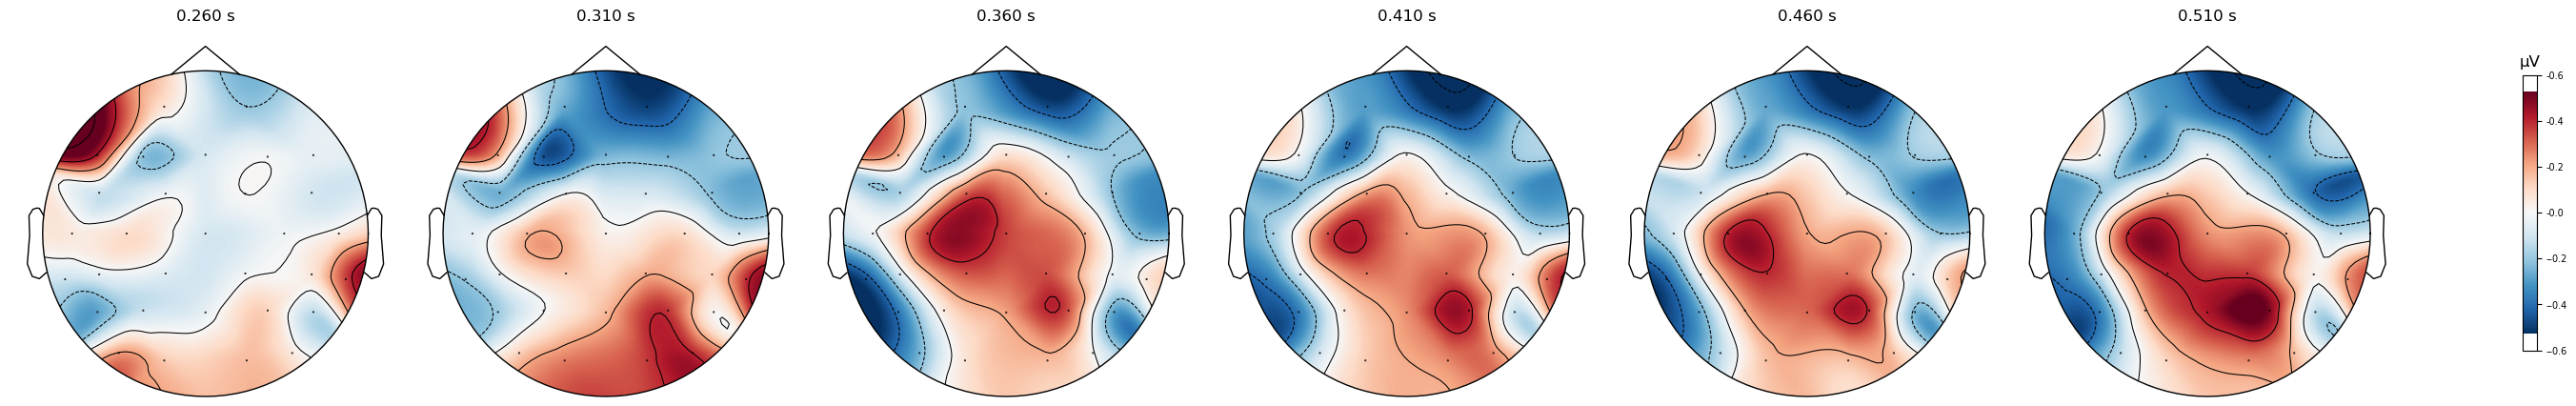

In [154]:
subtract_evoked = mne.combine_evoked([hc_hct_grand, ssd_hct_grand], weights=[1, -1])
subtract_evoked.crop(time_min, time_max-0.01)
fig = subtract_evoked.plot_topomap(
    ch_type='eeg',
    times=np.arange(time_min+0.01, time_max-0.01, 0.05),
    cbar_fmt="-%0.1f",
    mask=significant_points,
    size=3,
    show_names=False,
    time_unit="s",
)

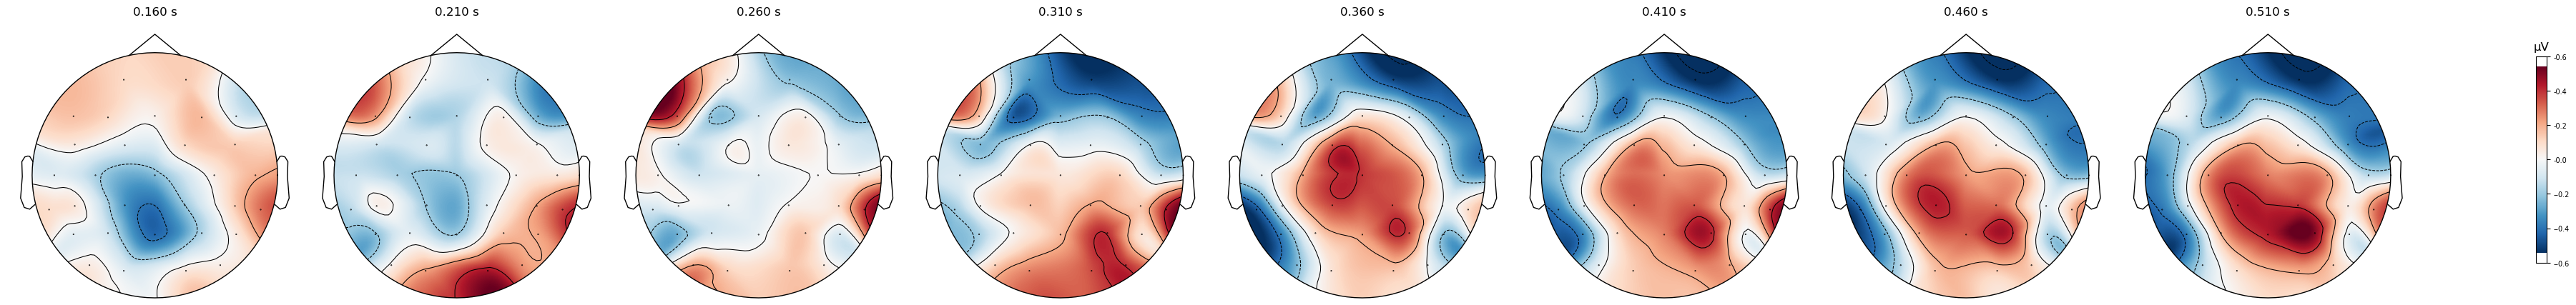

In [95]:
subtract_evoked = mne.combine_evoked([hc_ec_grand_average_hep_evoked, ssd_ec_grand_average_hep_evoked], weights=[1, -1])
subtract_evoked.crop(time_min, time_max-0.01)
fig = subtract_evoked.plot_topomap(
    ch_type='eeg',
    times=np.arange(time_min+0.01, time_max-0.01, 0.05),
    cbar_fmt="-%0.1f",
    mask=significant_points,
    size=3,
    show_names=False,
    time_unit="s",
)

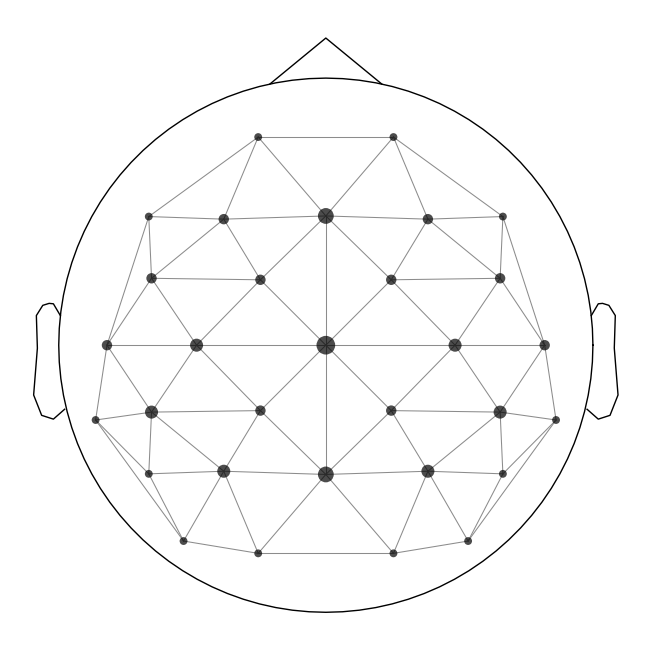

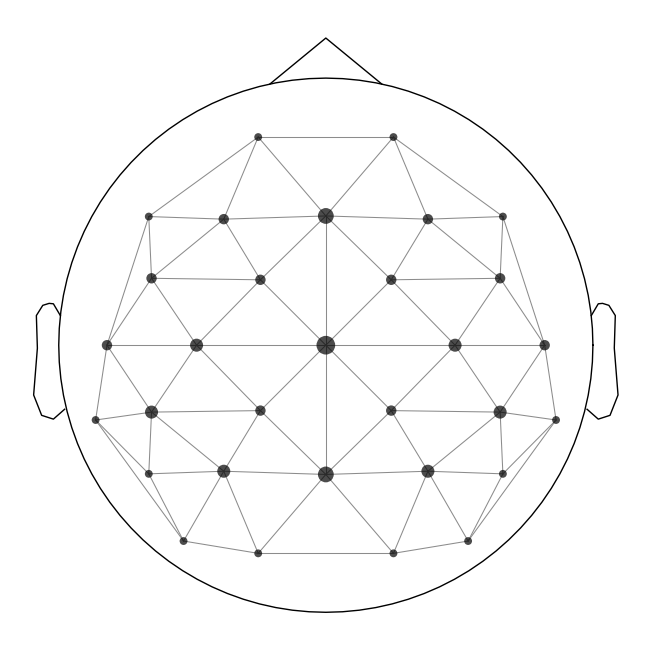

In [6]:
adjacency_plot = mne.viz.plot_ch_adjacency(info=evoked.info, adjacency=adjacency, ch_names=evoked.info['ch_names'])
adjacency_plot
